In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 这里的扰动量先设定为几个值，后面可视化展示不同的扰动量影响以及成像效果
epsilons = [0, .05, .1, .15, .2, .25, .3,.35,.4]
# 这个预训练的模型需要提前下载，下载链接如上
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

# 就是一个简单的模型结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 运行需要稍等，这里表示下载并加载数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 看看我们有没有配置GPU，没有就是使用cpu
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
model = Net().to(device)

# 加载前面的预训练模型
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 设置为验证模式. 
model.eval()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # 使用sign（符号）函数，将对x求了偏导的梯度进行符号化
    sign_data_grad = data_grad.sign()
    # 通过epsilon生成对抗样本
    perturbed_image = image + epsilon*sign_data_grad
    # 做一个剪裁的工作，将torch.clamp内部大于1的数值变为1，小于0的数值等于0，防止image越界
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回对抗样本
    return perturbed_image

In [4]:
def test( model, device, test_loader, epsilon ):

    # 准确度计数器
    correct = 0
    # 对抗样本
    adv_examples = []

    # 循环所有测试集
    for data, target in test_loader:
        # 将数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        # 设置张量的requires_grad属性。重要的攻击
        data.requires_grad = True

        # 通过模型向前传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 得到最大对数概率的索引

        # 如果最初的预测是错误的，不要再攻击了，继续下一个目标的对抗训练
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 使所有现有的梯度归零
        model.zero_grad()

        # 计算模型的后向梯度
        loss.backward()

        # 收集datagrad
        data_grad = data.grad.data

        # 调用FGSM攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 对受扰动的图像进行重新分类
        output = model(perturbed_data)

        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1] # 得到最大对数概率的索引
        if final_pred.item() == target.item():
            correct += 1
            # 这里都是为后面的可视化做准备
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 这里都是为后面的可视化做准备
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算最终精度
    final_acc = correct/float(len(test_loader))
    print("扰动量: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回准确性和对抗性示例
    return final_acc, adv_examples

In [3]:
accuracies = []
examples = []

# 对每个干扰程度进行测试
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc*100)
    examples.append(ex)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(np.arange(0, .5, step=0.05))
def to_percent(temp, position):
    return '%1.0f'%(temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.title("准确率 vs 扰动量")
plt.xlabel("扰动量")
plt.ylabel("准确率")
plt.show()

NameError: name 'fgsm_attack' is not defined

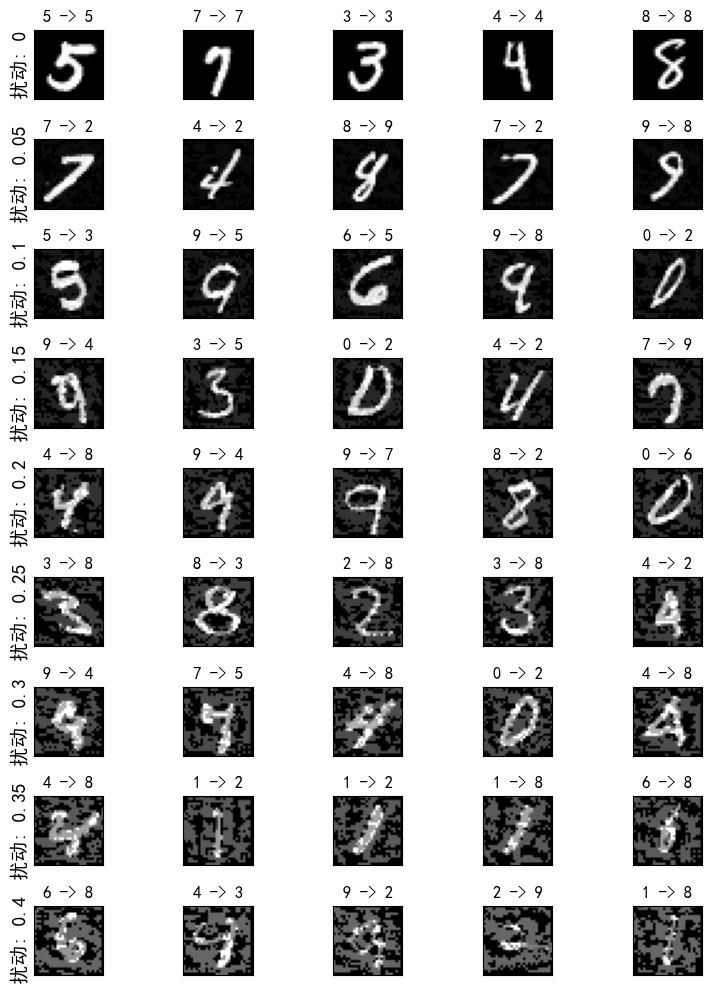

In [40]:
# 在每个处绘制几个对抗性样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("扰动: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()